###Черный Владислав 6511 - 2 вариант сложный (Autoencoder)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [ ]:
class Autoencoder(BaseEstimator):
    def __init__(self, input_dim, encoding_dim=5, epochs=40, batch_size=256):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def build_model(self):
        input_layer = tf.keras.layers.Input(shape=(self.input_dim,))
        encoded = tf.keras.layers.Dense(self.encoding_dim, activation='relu')(input_layer)
        decoded = tf.keras.layers.Dense(self.input_dim, activation='sigmoid')(encoded)
        self.model = tf.keras.models.Model(input_layer, decoded)
        self.model.compile(optimizer='adam', loss='mean_squared_error')

    def fit(self, X, y=None):
        self.build_model()
        self.model.fit(X, X, epochs=self.epochs, batch_size=self.batch_size, verbose=1)

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y=None):
        reconstructed = self.model.predict(X)
        error = np.mean(np.power(X - reconstructed, 2), axis=1)
        return -error.mean()

In [ ]:
df = pd.read_csv("dataset_2.csv")
df = df.dropna()

df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df["hour"] = df["datetime"].dt.hour / 24
df["day_of_week"] = df["datetime"].dt.weekday / 6


df = pd.get_dummies(df, columns=["scenario"], prefix="scenario") # ow и cw к числовым значениям
df["scenario_ow"] = df["scenario_ow"].astype(int)
df["scenario_cw"] = df["scenario_cw"].astype(int)


df = df.sort_values(by=["video_id", "timestamp"])
df_grouped = df.groupby("video_id").apply(lambda x: x).reset_index(drop=True)

# Формирование признаков, добавление лагов
lags = [1, 2, 3]
for lag in lags:
    df_grouped[f'lag_{lag}'] = df_grouped.groupby("video_id")['values'].shift(lag)

# Заполнение пропусков методом forward fill
df_grouped.ffill(inplace=True)

feature_columns = ["video_id", "hour", "day_of_week", "values", "scenario_ow", "scenario_cw"] + [f'lag_{lag}' for lag in lags]
df_grouped_features = df_grouped[feature_columns]


train_1, test_1 = train_test_split(range(1000), test_size=0.2, random_state=23)
print(train_1)
print(test_1)
train, test = train_test_split(df_grouped_features, test_size=0.2, random_state=23)  # Делим на тестовую и обучающую выборки


train_numerical = train.drop(columns=["video_id", "scenario_ow", "scenario_cw"])

train_mean = train_numerical.mean()
train_std = train_numerical.std()

#print(f"Training sample size before removing outliers: {train.shape[0]}")

train_filtered = train[~(np.abs(train_numerical - train_mean) > 3 * train_std).any(axis=1)] # Исключение выбросов

#print(f"Training sample size after removing outliers: {train_filtered.shape[0]}")

scaler = MinMaxScaler()

train_normalized = scaler.fit_transform(train_filtered.drop(columns=["scenario_ow", "scenario_cw"]))
train_normalized = pd.DataFrame(train_normalized, columns=train.drop(columns=["scenario_ow", "scenario_cw"]).columns)

test_normalized = scaler.transform(test.drop(columns=["scenario_ow", "scenario_cw"]))
test_normalized = pd.DataFrame(test_normalized, columns=test.drop(columns=["scenario_ow", "scenario_cw"]).columns)


train_normalized["scenario_ow"] = train_filtered["scenario_ow"].values
train_normalized["scenario_cw"] = train_filtered["scenario_cw"].values

test_normalized["scenario_ow"] = test["scenario_ow"].values
test_normalized["scenario_cw"] = test["scenario_cw"].values

train_normalized.ffill(inplace=True)

train_normalized = train_normalized.groupby("video_id").apply(lambda x: x).reset_index(drop=True)
test_normalized = test_normalized.groupby("video_id").apply(lambda x: x).reset_index(drop=True)

#train_normalized
#test_normalized

<ipython-input-12-d2ca6e38f7cc>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby("video_id").apply(lambda x: x).reset_index(drop=True)


[228, 45, 373, 813, 448, 826, 626, 915, 146, 343, 991, 728, 441, 319, 178, 421, 603, 74, 848, 3, 196, 995, 345, 59, 215, 22, 26, 253, 157, 816, 655, 847, 729, 415, 733, 749, 955, 477, 919, 983, 734, 819, 404, 860, 268, 689, 979, 161, 935, 502, 271, 96, 79, 143, 461, 270, 841, 1, 769, 350, 704, 406, 547, 434, 50, 835, 396, 392, 787, 773, 387, 964, 234, 390, 781, 555, 458, 763, 939, 545, 435, 127, 66, 408, 251, 677, 94, 399, 493, 470, 227, 436, 292, 512, 284, 91, 114, 948, 229, 906, 322, 326, 569, 727, 567, 673, 748, 433, 352, 893, 155, 73, 925, 261, 658, 774, 702, 140, 726, 309, 330, 691, 183, 51, 287, 778, 130, 801, 442, 670, 69, 940, 14, 866, 422, 346, 414, 606, 202, 584, 176, 966, 430, 892, 783, 123, 148, 124, 64, 58, 489, 133, 931, 483, 752, 34, 48, 431, 849, 975, 735, 115, 209, 257, 622, 90, 821, 985, 722, 305, 694, 596, 30, 398, 882, 165, 424, 407, 977, 423, 564, 454, 276, 798, 785, 916, 730, 463, 971, 863, 731, 857, 799, 946, 656, 457, 13, 535, 957, 159, 522, 484, 182, 274, 361, 

<ipython-input-12-d2ca6e38f7cc>:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_normalized = train_normalized.groupby("video_id").apply(lambda x: x).reset_index(drop=True)
<ipython-input-12-d2ca6e38f7cc>:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_normalized = test_normalized.groupby("video_id").apply(lambda x: x).reset_index(drop=True)


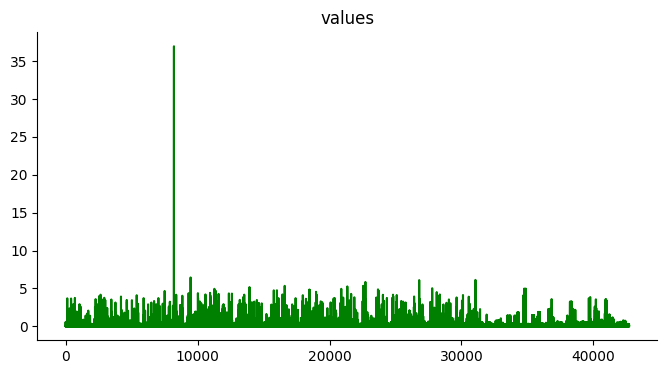

In [ ]:
from matplotlib import pyplot as plt
test_normalized['values'].plot(kind='line', figsize=(8, 4), title='values', color='green')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
param_grid = {
    "encoding_dim": [5, 10],
    "epochs": [30, 40],
    "batch_size": [32]
}

grid_search = GridSearchCV(
    estimator=Autoencoder(input_dim=train_normalized.shape[1]),
    param_grid=param_grid,
    scoring=make_scorer(Autoencoder.score, greater_is_better=False),
    cv=3,
    verbose=1
)

grid_search.fit(train_normalized)

best_params = grid_search.best_params_

# Best param: {'batch_size': 32, 'encoding_dim': 5, 'epochs': 30}

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0609
Epoch 2/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0045
Epoch 3/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0031
Epoch 4/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0027
Epoch 5/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0025
Epoch 6/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0023
Epoch 7/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0024
Epoch 8/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0023
Epoch 9/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0023
Epoch 10/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0023
Epoch 11/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0023
Epoch 12/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0023
Epoch 13/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0023
Epoch 14/30
3382/3382 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0770
Epoch 2/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0097
Epoch 3/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0085
Epoch 4/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0068
Epoch 5/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0062
Epoch 6/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0061
Epoch 7/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0061
Epoch 8/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0060
Epoch 9/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0060
Epoch 10/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0059
Epoch 11/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0059
Epoch 12/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0059
Epoch 13/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0059
Epoch 14/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0059
Epoch 15/30
3382/3382 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0598
Epoch 2/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0039
Epoch 3/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0027
Epoch 4/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0023
Epoch 5/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0021
Epoch 6/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0020
Epoch 7/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0019
Epoch 8/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0019
Epoch 9/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0019
Epoch 10/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0019
Epoch 11/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0018
Epoch 12/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0018
Epoch 13/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0018
Epoch 14/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0018
Epoch 15/30
3382/3382 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0637
Epoch 2/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0064
Epoch 3/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0048
Epoch 4/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0033
Epoch 5/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0028
Epoch 6/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0026
Epoch 7/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0024
Epoch 8/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0024
Epoch 9/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0023
Epoch 10/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0023
Epoch 11/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0022
Epoch 12/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0022
Epoch 13/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0022
Epoch 14/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0022
Epoch 15/40
3382/3382 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


3382/3382 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - loss: 0.0593
Epoch 2/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0049
Epoch 3/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0035
Epoch 4/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0030
Epoch 5/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0027
Epoch 6/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0025
Epoch 7/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0025
Epoch 8/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0024
Epoch 9/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0023
Epoch 10/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0022
Epoch 11/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0020
Epoch 12/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0018
Epoch 13/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0017
Epoch 14/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0016
Epoch 15/40
3382/3382 ━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0485
Epoch 2/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0047
Epoch 3/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0026
Epoch 4/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0021
Epoch 5/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0020
Epoch 6/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0019
Epoch 7/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0018
Epoch 8/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0018
Epoch 9/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0018
Epoch 10/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0018
Epoch 11/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0017
Epoch 12/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0017
Epoch 13/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0017
Epoch 14/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0018
Epoch 15/40
3382/3382 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0449
Epoch 2/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0022
Epoch 3/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 8.8876e-04
Epoch 4/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 8.3240e-04
Epoch 5/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 7.7497e-04
Epoch 6/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 6.7616e-04
Epoch 7/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 5.8908e-04
Epoch 8/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.5598e-04
Epoch 9/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.3300e-04
Epoch 10/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 5.1551e-04
Epoch 11/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.0777e-04
Epoch 12/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 4.9709e-04
Epoch 13/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.7819e-04
Epoch 14/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.6

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0447
Epoch 2/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0019
Epoch 3/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 8.8725e-04
Epoch 4/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 8.0540e-04
Epoch 5/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 7.5246e-04
Epoch 6/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 7.0456e-04
Epoch 7/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 6.3232e-04
Epoch 8/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.9153e-04
Epoch 9/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 5.6393e-04
Epoch 10/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 5.2566e-04
Epoch 11/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 4.8845e-04
Epoch 12/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.5775e-04
Epoch 13/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.4341e-04
Epoch 14/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0490
Epoch 2/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0020
Epoch 3/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 8.2429e-04
Epoch 4/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 7.5295e-04
Epoch 5/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 7.0001e-04
Epoch 6/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 6.5154e-04
Epoch 7/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 6.0750e-04
Epoch 8/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.9117e-04
Epoch 9/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 5.8440e-04
Epoch 10/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 5.8092e-04
Epoch 11/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 5.7690e-04
Epoch 12/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.8069e-04
Epoch 13/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 5.7113e-04
Epoch 14/30
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0504
Epoch 2/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0033
Epoch 3/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0011
Epoch 4/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 9.5964e-04
Epoch 5/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 9.1847e-04
Epoch 6/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 8.9378e-04
Epoch 7/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 8.7953e-04
Epoch 8/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 8.6499e-04
Epoch 9/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 8.5043e-04
Epoch 10/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 8.3882e-04
Epoch 11/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 8.3819e-04
Epoch 12/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 8.2081e-04
Epoch 13/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 8.2487e-04
Epoch 14/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 8.1300

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0420
Epoch 2/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0017
Epoch 3/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 8.8618e-04
Epoch 4/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 8.2248e-04
Epoch 5/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 7.9995e-04
Epoch 6/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 7.7186e-04
Epoch 7/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 7.5312e-04
Epoch 8/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 7.3354e-04
Epoch 9/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 7.0815e-04
Epoch 10/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 6.9119e-04
Epoch 11/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 6.6384e-04
Epoch 12/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 6.5031e-04
Epoch 13/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 6.4445e-04
Epoch 14/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0577
Epoch 2/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0027
Epoch 3/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0014
Epoch 4/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 9.2357e-04
Epoch 5/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 8.7666e-04
Epoch 6/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 8.1512e-04
Epoch 7/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 7.7572e-04
Epoch 8/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 7.5887e-04
Epoch 9/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 7.3112e-04
Epoch 10/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 7.1839e-04
Epoch 11/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 7.0274e-04
Epoch 12/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 6.9068e-04
Epoch 13/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.7838e-04
Epoch 14/40
3382/3382 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 6.79

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


5073/5073 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0561
Epoch 2/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0046
Epoch 3/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0041
Epoch 4/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0041
Epoch 5/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0041
Epoch 6/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0041
Epoch 7/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0040
Epoch 8/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0040
Epoch 9/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0040
Epoch 10/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0040
Epoch 11/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0039
Epoch 12/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0040
Epoch 13/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0040
Epoch 14/30
5073/5073 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0040
Epoch 15/30
5073/5073 ━━━━━━━━━

Epoch 1/30
5073/5073 - 7s - 1ms/step - loss: 0.0181
Epoch 2/30
5073/5073 - 11s - 2ms/step - loss: 0.0029
Epoch 3/30
5073/5073 - 6s - 1ms/step - loss: 0.0024
Epoch 4/30
5073/5073 - 7s - 1ms/step - loss: 0.0022
Epoch 5/30
5073/5073 - 9s - 2ms/step - loss: 0.0022
Epoch 6/30
5073/5073 - 9s - 2ms/step - loss: 0.0022
Epoch 7/30
5073/5073 - 7s - 1ms/step - loss: 0.0021
Epoch 8/30
5073/5073 - 9s - 2ms/step - loss: 0.0021
Epoch 9/30
5073/5073 - 10s - 2ms/step - loss: 0.0021
Epoch 10/30
5073/5073 - 7s - 1ms/step - loss: 0.0021
Epoch 11/30
5073/5073 - 9s - 2ms/step - loss: 0.0020
Epoch 12/30
5073/5073 - 10s - 2ms/step - loss: 0.0018
Epoch 13/30
5073/5073 - 7s - 1ms/step - loss: 0.0015
Epoch 14/30
5073/5073 - 9s - 2ms/step - loss: 0.0014
Epoch 15/30
5073/5073 - 7s - 1ms/step - loss: 0.0014
Epoch 16/30
5073/5073 - 10s - 2ms/step - loss: 0.0014
Epoch 17/30
5073/5073 - 9s - 2ms/step - loss: 0.0014
Epoch 18/30
5073/5073 - 10s - 2ms/step - loss: 0.0014
Epoch 19/30
5073/5073 - 7s - 1ms/step - loss: 0.00

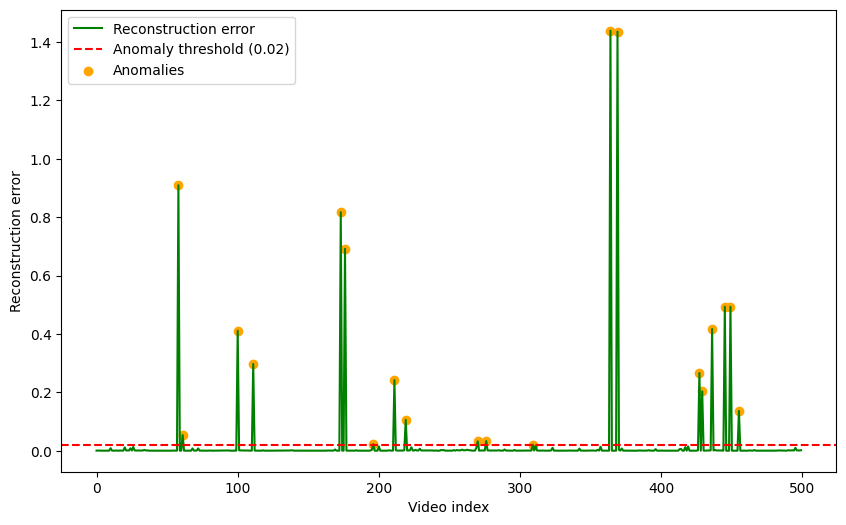

In [ ]:
autoencoder = Autoencoder(input_dim=train_normalized.shape[1], encoding_dim=5, epochs=30, batch_size=32)

autoencoder.fit(train_normalized)

reconstructed_data = autoencoder.predict(test_normalized)

errors = np.mean(np.power(test_normalized.values - reconstructed_data, 2), axis=1)

threshold = np.percentile(errors, 95)

errors_for_show = errors[15000:15500]

plt.figure(figsize=(10, 6))
plt.plot(errors_for_show, label='Reconstruction error', color='green')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Anomaly threshold ({threshold:.2f})')

anomalies = errors_for_show > threshold
plt.scatter(np.where(anomalies), errors_for_show[anomalies], color='orange', label='Anomalies')

plt.xlabel('Video index')
plt.ylabel('Reconstruction error')
plt.legend()
plt.show()